In [1]:
import pandas as pd
import datajoint as dj
dj.config['database.host'] = '10.86.1.219'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'retina'
dj.config["enable_python_native_blobs"] = True # Only for testing in dj0.12 (https://github.com/datajoint/datajoint-python#python-native-blobs)

%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE

import main
import seaborn as sns
drive_path = r"\\NERFHF01/djnerf1/VEIDB/"
# data_path = r"Y:\Data"
data_path =r"W:\Data/"
ft = main.load(drive_path, data_path)

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@10.86.1.219:3306


In [2]:
from datetime import date
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
import os
from matplotlib.gridspec import GridSpec
import seaborn as sb
sb.set_style('dark')

In [3]:
exp_table = ft.Experiment()
sess_table = ft.Session()
mouse_table = ft.Mouse()
subsess_table = ft.Subsession()
raw_table = ft.ephys_tables.EphysRaw()
raw_table_helper = ft.ephys_tables.EphysRawHelper()
subsess_events_table = ft.event_tables.SubsessionEvents()
subsess_spikes_table = ft.ephys_tables.SubsessionSpikes()
trial_events_table = ft.event_tables.TrialEvents()

sorted_table = ft.ephys_tables.SpikeSorted()

In [4]:
def smooth_spikecounts(spikecounts, sigma=2):
    return ndimage.gaussian_filter1d(spikecounts, sigma)

def filter_clusters(clusters, cluster_annot, annot=['good']):
    clusters_filtered = {}
    for c in cluster_annot:
        if cluster_annot[c] in annot:
            clusters_filtered[c] = clusters.get(c)
    return clusters_filtered
                

def plot_spike_raster(clusters, start, end, ax, event_times=None, colored=False, color_palette=None, visualize_depth=False, cluster_depths=None):
    data = []

    for c, cl_spike_times in clusters.items():
        if cl_spike_times is not None and isinstance(cl_spike_times, np.ndarray):
            cl_spike_times_sub = cl_spike_times[(cl_spike_times >= start) & (cl_spike_times < end)]
            data.append((c, cl_spike_times_sub))
            
    for i, (cluster, cl_spike_times) in enumerate(data[:]):
        if visualize_depth:
            depth = cluster_depths[cluster]
        else:
            depth = cluster
            
        if colored:
            color = color_palette[random.randint(0, len(color_palette)-1)]
            ax.scatter(np.array(cl_spike_times)/30000, np.ones_like(cl_spike_times)*depth, marker='|', c=[color]) # SCATTER PLOT
        else:
            ax.scatter(np.array(cl_spike_times)/30000, np.ones_like(cl_spike_times)*depth, marker='|', c=[(0, 0, 0, 0.4)]) # SCATTER PLOT
    
    ax.set_ylabel('depth')
    ax.set_xlabel('time (s)')
    if event_times is not None:
        event_types_and_times = list(zip(*[(i, t) for tup in event_times for (i, t) in enumerate(tup)]))
        event_types = np.array(event_types_and_times[0]) 
        event_times = np.array(event_types_and_times[1])
        event_times_sub = event_times[(event_times >= start) & (event_times < end)]
        event_types_sub = event_types[(event_times >= start) & (event_times < end)]
        for event in event_times_sub:
            ax.axvline(event/30000, ymin=0, ymax=1, c='r', alpha=0.8)
            
def spikes_2_spikecounts(clusters, start, end, binsize=30):
    """Excludes neurons that don't fire"""
    first_spike_time = min([s[0] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0], default=0)    
    last_spike_time = max([s[-1] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0], default=0)    
    fr_clusters = {}
    for i, (c, cl_spike_times) in enumerate(clusters.items()):
        if cl_spike_times is not None:
            cl_spike_times_sub = cl_spike_times[(cl_spike_times >= start) & (cl_spike_times < end)]
            fr, _ = np.histogram(cl_spike_times_sub, bins=np.arange(start, end, (30000/1000)*binsize))
            fr_clusters[c] = np.float32(fr)
    return fr_clusters

def plot_spikecounts_mean(fr_clusters, ax, mean=True, event_times=None):
    trial_frs = []
    for j, (c, firing_rate) in enumerate(fr_clusters.items()):
#         axs[i].plot(np.ones_like(firing_rate)*c*1, firing_rate)
        trial_frs.append(firing_rate)
    ax.plot(np.mean(np.array(trial_frs), axis=0))


In [5]:
def get_spiking_tensor(session_key, stim, before=int(30000*0.1), after=0):    
    subsess_key = {'subsession_type': stim, 'experiment_id': session_key['experiment_id'], 'session_id': session_key['session_id']}
    cluster_info, clusters = (subsess_spikes_table & subsess_key).fetch1('cluster_info', 'clusters')
    clusters_good = [c for c, annot in cluster_info['group'].items() if annot == 'good']
    
    trial_starts, trial_ends = (subsess_events_table & subsess_key).fetch1('trials_starts', 'trials_ends')
    trial_lengths = [e-s for s, e in zip(trial_starts, trial_ends)]
    print("Trial lengths: ", trial_lengths)

    n_trials, n_neurons, window_size = len(trial_starts), len(clusters_good), int(max(trial_lengths)+before+after)  
    spiking_tensor = np.zeros(shape=(n_trials, n_neurons, window_size))
    spiking_tensor_meta = np.zeros(shape=(n_neurons))
    for trial_idx, (start, end) in enumerate(zip(trial_starts, trial_ends)):
        for c_idx, c in enumerate(clusters_good):
            c_activity = clusters.get(c, None)
            if c_activity is not None:
                spiking_activity = c_activity[(c_activity >= start-before) & (c_activity < end+after)] - start - before
#                 print(spiking_activity)
                spiking_tensor[trial_idx, c_idx, spiking_activity] = 1
            spiking_tensor_meta[c_idx] = c
    
    return spiking_tensor, spiking_tensor_meta

def get_fr_tensor(subsess_key, before=int(30000*0.1), after=0, binsize=25):    
    cluster_info, clusters = (subsess_spikes_table & subsess_key).fetch1('cluster_info', 'clusters')
    clusters_good = [c for c, annot in cluster_info['group'].items() if annot == 'good']
    
    trial_starts, trial_ends = (subsess_events_table & subsess_key).fetch1('trials_starts', 'trials_ends')
    trial_lengths = [e-s for s, e in zip(trial_starts, trial_ends)]
    print("Trial lengths: ", trial_lengths)

    n_trials, n_neurons, window_size = len(trial_starts), len(clusters_good), int(max(trial_lengths)+before+after)  
    n_bins = int((window_size*1000)/(30000*binsize))
    fr_tensor = np.zeros(shape=(n_trials, n_neurons, n_bins))
    fr_tensor_meta = np.zeros(shape=(n_neurons))
    for trial_idx, (start, end) in enumerate(zip(trial_starts, trial_ends)):
        for c_idx, c in enumerate(clusters_good):
            c_activity = clusters.get(c, None)
            if c_activity is not None:
                spiking_activity = c_activity[(c_activity >= start-before) & (c_activity < end+after)]
                fr, _ = np.histogram(spiking_activity, bins=np.arange(start-before, end+after, (30000/1000)*binsize))
#                 print(fr)
                fr_tensor[trial_idx, c_idx, :len(fr)] = smooth_spikecounts(fr, sigma=0.5)
            fr_tensor_meta[c_idx] = c
    
    # Extract baseline fr
    baseline_window = 30000#trial_starts[0]-1
    baseline_fr = np.zeros(shape=(n_neurons, int((baseline_window*1000)/(30000*binsize))))
    for c_idx, c in enumerate(clusters_good):
        c_activity = clusters.get(c, None)
        if c_activity is not None:
            spiking_activity = c_activity[(c_activity < baseline_window)]
            fr, _ = np.histogram(spiking_activity, bins=np.arange(0, baseline_window, (30000/1000)*binsize))
#                 print(fr)
            baseline_fr[c_idx, :len(fr)] = smooth_spikecounts(fr, sigma=0.5)
    return fr_tensor, fr_tensor_meta, baseline_fr


In [6]:
# sessions = [{'experiment_id': '01230', 'session_id': '20200326a'}, {'experiment_id': '01231', 'session_id': '20200327a'}, {'experiment_id': '01232', 'session_id': '20200328a'}]
sessions = [{'experiment_id': '01231', 'session_id': '20200327a'}, {'experiment_id': '01232', 'session_id': '20200328a'}, {'experiment_id': '01261', 'session_id': '20200327f'}, {'experiment_id': '01247', 'session_id': '20200328e'}]
# at least 2330
sessions_sSC_depths = [(1900, 2250), (2100, 2450), (2250, 2550), (2800, 3100)]

In [7]:
figures_folder = os.path.join(r"C:\Users\bramn\Documents\Projects\DatajointVEIDB\images\selectivity")
if not os.path.isdir(figures_folder):
    os.mkdir(figures_folder)
    
stims_vis = ['EXPA', 'DIMM', 'CHPE', 'EXPW']

In [8]:
def load_session(session_key):
    print(session_key)
    stims_dict = {}
    for stim in stims_vis:
        stims_dict[stim] = {}
        subsess_key = session_key
        subsess_key['subsession_type'] = stim
        fr_tensor, fr_tensor_meta, baseline_fr = get_fr_tensor(subsess_key, binsize=30, before=int(30000*0), after=int(30000*0))
        subsess_key = {'subsession_type': stim, 'experiment_id': session_key['experiment_id'], 'session_id': session_key['session_id']}
        stims_dict[stim]['key'] = subsess_key
        stims_dict[stim]['fr_tensor'] = fr_tensor
        stims_dict[stim]['fr_tensor_meta'] = fr_tensor_meta
        stims_dict[stim]['baseline'] = baseline_fr
    return stims_dict
        
sessions_list = []
for sess in sessions:
    sessions_list.append(load_session(sess))

# padding = 0
# binsize = 25
# smooth_sigma = 1
# n_trials = 4 

# spiking_tensor, spiking_tensor_meta = get_spiking_tensor(sessions[0], 'EXPA')
# fr_tensor, fr_tensor_meta = get_fr_tensor(sessions[0], 'DIMM')

{'experiment_id': '01231', 'session_id': '20200327a'}
Trial lengths:  [24999, 24995, 25000, 24995, 25001, 25001, 25000, 25001, 25000, 24999]
Trial lengths:  [24996, 25000, 25000, 25007, 25002, 25000, 25000, 25000, 24995, 25000]
Trial lengths:  [962490, 962502, 962494, 962494, 962494, 962495, 962495, 962496, 962500, 962491]
Trial lengths:  [24995, 24991, 24994, 24999, 25002, 24999, 25000, 25005, 25001, 25000]
{'experiment_id': '01232', 'session_id': '20200328a'}
Trial lengths:  [25000, 24988, 25000, 25000, 24998, 25008, 25000, 25000, 25001, 25002]
Trial lengths:  [25001, 25001, 24999, 25002, 25007, 24996, 25001, 25000, 25001, 25000]
Trial lengths:  [962496, 962496, 962496, 962496, 962495, 962495, 962495, 962494, 962494, 962494]
Trial lengths:  [25000, 24999, 24994, 25000, 25000, 25000, 25000, 24993, 25001, 24994]
{'experiment_id': '01261', 'session_id': '20200327f'}
Trial lengths:  [24999, 24999, 25001, 25001, 25000, 25001, 25001, 25000, 25000, 25004]
Trial lengths:  [25002, 25001, 2499

In [9]:
sessions_list[0]['EXPA']['baseline'].shape

(203, 33)

In [10]:
import numpy as np
a = np.array([5, 1, 2])
a[np.argsort(a)]

array([1, 2, 5])

In [11]:
sessions_sSC_depths

[(1900, 2250), (2100, 2450), (2250, 2550), (2800, 3100)]

In [12]:
EXPA_fr_list = []
EXPA_basefr_list = []
DIMM_fr_list = []
DIMM_basefr_list = []
CHPE_fr_list = []
CHPE_basefr_list = []
EXPW_fr_list = []
EXPW_basefr_list = []

relat_depth_list = []
for sess, (sSC_begin, sSC_end) in zip(sessions_list, sessions_sSC_depths):
    cluster_info = (sorted_table & sess['EXPA']['key']).fetch1('cluster_info')
    
    """ Might contain a bug!! Check!"""
    cluster_depths = np.array(list(map(lambda x: cluster_info['depth'][x], sess['EXPA']['fr_tensor_meta'])))
    sorted_idxs = np.argsort(cluster_depths)
    print(sorted_idxs.shape)
    SC_filter = ((cluster_depths >= sSC_end-1100) & (cluster_depths <= sSC_end))[sorted_idxs] #1100 includes both sSC and dSC (Meister)
    print(SC_filter.shape)
    SC_idxs = sorted_idxs[SC_filter]
    
    EXPA_fr_list.append(sess['EXPA']['fr_tensor'][:,SC_idxs,:])
    DIMM_fr_list.append(sess['DIMM']['fr_tensor'][:,SC_idxs,:])
    CHPE_fr_list.append(sess['CHPE']['fr_tensor'][:,SC_idxs,:])
    EXPW_fr_list.append(sess['EXPW']['fr_tensor'][:,SC_idxs,:])
    
    EXPA_basefr_list.append(sess['EXPA']['baseline'][SC_idxs])
    DIMM_basefr_list.append(sess['DIMM']['baseline'][SC_idxs])
    CHPE_basefr_list.append(sess['CHPE']['baseline'][SC_idxs])
    EXPW_basefr_list.append(sess['EXPW']['baseline'][SC_idxs])
    
    relat_depth_list.append(cluster_depths[SC_idxs]-sSC_begin)
    
# EXPA_fr = np.concatenate([sess['EXPA']['fr_tensor'] for sess in sessions_list], axis=1)
# DIMM_fr = np.concatenate([sess['DIMM']['fr_tensor'] for sess in sessions_list], axis=1)
# CHPE_fr = np.concatenate([sess['CHPE']['fr_tensor'] for sess in sessions_list], axis=1)
EXPA_fr = np.concatenate(EXPA_fr_list, axis=1)
DIMM_fr = np.concatenate(DIMM_fr_list, axis=1)
CHPE_fr = np.concatenate(CHPE_fr_list, axis=1)
EXPW_fr = np.concatenate(EXPW_fr_list, axis=1)

EXPA_basefr = np.concatenate(EXPA_basefr_list, axis=0)
DIMM_basefr = np.concatenate(DIMM_basefr_list, axis=0)
CHPE_basefr = np.concatenate(CHPE_basefr_list, axis=0)
EXPW_basefr = np.concatenate(EXPW_basefr_list, axis=0)

relat_depth = np.concatenate(relat_depth_list)

(203,)
(203,)
(260,)
(260,)
(469,)
(469,)
(261,)
(261,)


In [13]:
a = np.array([5, 4, 1, 2, 3])
a[np.argsort(a)]

array([1, 2, 3, 4, 5])

In [14]:
EXPA_basefr.shape

(373, 33)

In [15]:
""" Sort all neurons based on depth"""
relat_depth_sorted_idxs = np.argsort(relat_depth)
EXPA_fr = EXPA_fr[:,relat_depth_sorted_idxs]
DIMM_fr = DIMM_fr[:,relat_depth_sorted_idxs]
CHPE_fr = CHPE_fr[:,relat_depth_sorted_idxs]
EXPW_fr = EXPW_fr[:,relat_depth_sorted_idxs]

EXPA_basefr = EXPA_basefr[relat_depth_sorted_idxs]
DIMM_basefr = DIMM_basefr[relat_depth_sorted_idxs]
CHPE_basefr = CHPE_basefr[relat_depth_sorted_idxs]
EXPW_basefr = EXPW_basefr[relat_depth_sorted_idxs]

In [16]:
EXPA_basefr_mean = np.mean(EXPA_basefr, axis=1)
DIMM_basefr_mean = np.mean(DIMM_basefr, axis=1)
CHPE_basefr_mean = np.mean(CHPE_basefr, axis=1)
EXPW_basefr_mean = np.mean(EXPW_basefr, axis=1)

EXPA_basefr_std = np.std(EXPA_basefr, axis=1)
DIMM_basefr_std = np.std(DIMM_basefr, axis=1)
CHPE_basefr_std = np.std(CHPE_basefr, axis=1)
EXPW_basefr_std = np.std(EXPW_basefr, axis=1)

In [17]:
A = EXPA_fr[0]
A_base_mean = EXPA_basefr_mean
A_base_std = EXPA_basefr_std
# B = DIMM_fr[0]
# B_base_mean = DIMM_basefr_mean
# B_base_std = DIMM_basefr_std
B = EXPW_fr[0]
B_base_mean = EXPW_basefr_mean
B_base_std = EXPW_basefr_std

In [18]:
visually_responsive_neurons = ((np.mean(((A.T-A_base_mean)/A_base_std).T, axis=1)+
                                np.mean(((B.T-B_base_mean)/B_base_std).T, axis=1))/2 > 0.01)

c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [19]:
A.shape

(373, 27)

In [20]:
""" Selectivity chosen as any postivie repsonse -> inhibited neurons are ignored"""
# r_EXPA = np.clip(np.sum(EXPA_fr, axis=(0, 2)) - EXPA_basefr*EXPA_fr.shape[0]*EXPA_fr.shape[2], a_min=0, a_max=None)
# r_DIMM = np.clip(np.sum(DIMM_fr, axis=(0, 2)) - DIMM_basefr*DIMM_fr.shape[0]*DIMM_fr.shape[2], a_min=0, a_max=None)

# r_EXPA = np.abs(np.sum(EXPA_fr[0], axis=(1)) - EXPA_basefr*EXPA_fr.shape[2])
# r_DIMM = np.abs(np.sum(DIMM_fr[0], axis=(1)) - DIMM_basefr*DIMM_fr.shape[2])
r_A = np.clip(np.sum(A, axis=(1)) - A_base_mean*A.shape[1], a_min=0, a_max=None)
r_B = np.clip(np.sum(B, axis=(1)) - B_base_mean*B.shape[1], a_min=0, a_max=None)
# r_EXPA = np.mean(EXPA_fr, axis=(0, 2)) - EXPA_basefr
# r_DIMM = np.mean(DIMM_fr, axis=(0, 2)) - DIMM_basefr

In [21]:
# EXPA_fr
np.max(A_base_mean)

1.7272727272727273

In [22]:
selectivity_indexes = ((r_A-r_B)/(r_A+r_B))

c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [23]:
np.argmin(r_A)

2

In [24]:
np.min(selectivity_indexes[visually_responsive_neurons])

-1.0

In [25]:
np.max(selectivity_indexes[visually_responsive_neurons])

1.0

In [26]:
max(selectivity_indexes)

1.0

In [27]:
sb_colors = sb.color_palette()
sb.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

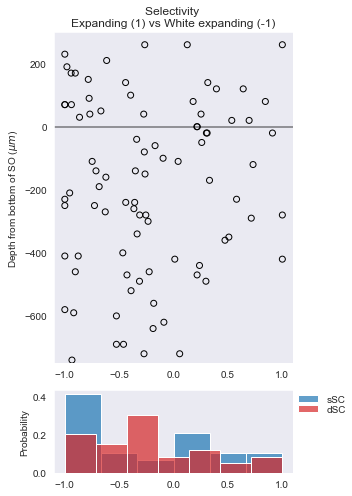

In [28]:
# fig, axs = plt.subplots(2, 1, figsize=(5, 8))
plt.rcParams.update({'font.family': 'Arial'})

fig = plt.figure(constrained_layout=False, figsize=(5, 7))
gs = GridSpec(2, 1, figure=fig, height_ratios=[4, 1])
ax_scatter = fig.add_subplot(gs[0])
ax_dist = fig.add_subplot(gs[1], sharex=ax_scatter)


ax_scatter.scatter(selectivity_indexes[visually_responsive_neurons], relat_depth[relat_depth_sorted_idxs][visually_responsive_neurons], facecolors='none', edgecolors='k')
# ax_scatter.xlim(-1.2, 1.2)
ax_scatter.set(ylim=[-750, 300], ylabel=r'Depth from bottom of SO ($\mu m$)')
ax_scatter.axhline(c='k', alpha=0.5)
ax_scatter.set_title('Selectivity \nExpanding (1) vs White expanding (-1)')

sb.histplot(selectivity_indexes[visually_responsive_neurons][relat_depth[relat_depth_sorted_idxs][visually_responsive_neurons]>=0], ax=ax_dist, color=sb_colors[0], alpha=0.7, stat='probability', label='sSC')
sb.histplot(selectivity_indexes[visually_responsive_neurons][relat_depth[relat_depth_sorted_idxs][visually_responsive_neurons]<0], ax=ax_dist, color=sb_colors[3], alpha=0.7, stat='probability', label='dSC')
# ax_scatter.set_xticklabels([])
ax_dist.legend(loc='upper left', bbox_to_anchor=(1, 1), borderpad=0, labelspacing=0.1, frameon=False, ncol=1)
plt.tight_layout()
plt.savefig('selectivity_EXPAEXPW_inclGRP.png', dpi=150)
# ax_dist.legend()
plt.show()

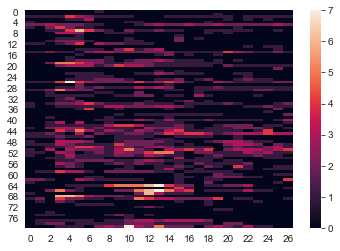

In [505]:
sb.heatmap(A[visually_responsive_neurons])

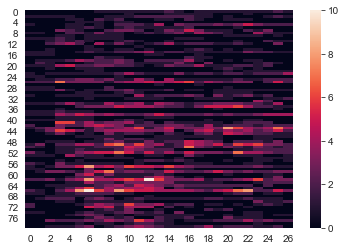

In [507]:
sb.heatmap(B[visually_responsive_neurons])

In [321]:
np.sum(EXPA_fr[0][175] + DIMM_fr[0][175])

10.0

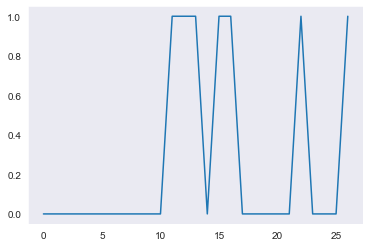

In [294]:
plt.plot(DIMM_fr[0][175])

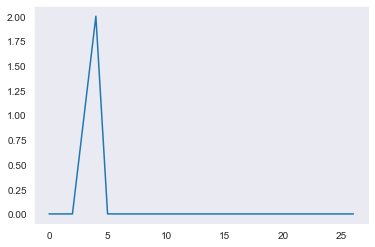

In [295]:
plt.plot(EXPA_fr[0][175])